In [1]:
# import libraries
import fastai
from fastai import *
from fastai.text import * 
import pandas as pd
import numpy as np
from functools import partial
import io
import os
import tarfile
import requests
import nltk
nltk.download('words')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import spacy
from wordcloud import WordCloud
from textblob import TextBlob
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
import seaborn as sns
!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import gensim.corpora as corpora
from pprint import pprint
import pickle 
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors
# !pip install --upgrade gensim


[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
#download the data from fast.ai using requests
url = 'https://s3.amazonaws.com/fast-ai-nlp/amazon_review_full_csv.tgz'
response = requests.get(url, stream=True)

#open the tar file using tarfile
file = tarfile.open(fileobj=response.raw, mode='r|gz')
file.extractall(path=".")

In [2]:
#import the training set and name the columns
cols = ["target", "title", "comment"]
data = pd.read_csv("./amazon_review_full_csv/train.csv", names = cols)

In [3]:
#view the first 5 rows of df
data.head()

,target,title,comment
0,3,more like funchuck,Gave this to my dad for a gag gift after direc...
1,5,Inspiring,I hope a lot of people hear this cd. We need m...
2,5,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
3,4,Chrono Cross OST,The music of Yasunori Misuda is without questi...
4,5,Too good to be true,Probably the greatest soundtrack in history! U...


In [4]:
#view df shape
data.shape

(3000000, 3)

In [5]:
#check for null values
data.isnull().sum()

target      0
title      76
comment     0
dtype: int64

In [6]:
#view null title data 
data[data.title.isnull()]

,target,title,comment
22001,2,NaN,What separates this band from Evanescence (bes...
104196,4,NaN,I would highly recommend this book. It tells t...
124729,2,NaN,"This Japanese band produces noisy, psychotic R..."
144733,2,NaN,this cd isnt band but i wouldnt buy it because...
222764,3,NaN,"value for the money. enjoyable, convenient, ea..."
...,...,...,...
2713461,1,NaN,I was extremely dissatisfied with this book - ...
2745595,1,NaN,Can't write a review- it's been a month since ...
2783169,3,NaN,The game is quite a game actually u can use di...
2878211,5,NaN,I've been using this mouse pad for a little ov...


In [7]:
#replace null titles with empty space for later processing 
data['title'] = data['title'].fillna(" ")

In [8]:
#Keep only Negative (1) and Positive(5) reviews for sentiment analysis
key = [1,5]
data= data[data.target.isin(key)]

# sample 20k rows from data with equal distribution across sentiment
train_df = data.groupby('target').apply(lambda x: x.sample(n=10000)).reset_index(drop = True)

#shuffle rows 
train_df = train_df.sample(frac=1).reset_index(drop=True)

#combine title and comment data for analysis 
train_df['text'] = train_df['title'] + " " + train_df['comment']

#drop original columns
train_df = train_df.drop(['comment','title'], axis=1)

#reset index and drop original index values
train_df = train_df.reset_index(drop = True)

In [9]:
#view first 5 rows 
train_df.head()

,target,text
0,1,VERY DISAPPOINTED!!! Super Thin and NOT absorb...
1,5,"YOU HAVE TO READ THIS BOOK!!!! ""Toddler"" is an..."
2,5,"And a movie, too. In these books, the author s..."
3,5,Great! I bought this book as well as the Test ...
4,1,UN-BEAR-ABLE I agree with the guy in this film...


In [10]:
#get sentiment analysis from vader for 0 and 1 target

#create analyzer 
vader = SentimentIntensityAnalyzer()
sent_df = train_df.copy()

#save vader score per comment 
sent_df['compound'] = [vader.polarity_scores(x)['compound'] for x in sent_df['text']]
sent_df['neg'] = [vader.polarity_scores(x)['neg'] for x in sent_df['text']]
sent_df['neu'] = [vader.polarity_scores(x)['neu'] for x in sent_df['text']]
sent_df['pos'] = [vader.polarity_scores(x)['pos'] for x in sent_df['text']]

In [11]:
#view sentiment scores for 1 star comments
sent_df[sent_df['target']==1].head()

,target,text,compound,neg,neu,pos
0,1,VERY DISAPPOINTED!!! Super Thin and NOT absorb...,0.9052,0.055,0.809,0.136
4,1,UN-BEAR-ABLE I agree with the guy in this film...,0.1071,0.152,0.685,0.162
5,1,Disappointed I should have read the reviews be...,0.1644,0.034,0.905,0.061
8,1,The sum is just as crappy as its parts! I was ...,0.5005,0.086,0.848,0.066
9,1,Better left to guys with a pony tail It is obv...,-0.0083,0.072,0.857,0.071


In [12]:
#view sentiment scores for 5 star comments
sent_df[sent_df['target']==5].head()

,target,text,compound,neg,neu,pos
1,5,"YOU HAVE TO READ THIS BOOK!!!! ""Toddler"" is an...",0.8208,0.035,0.879,0.086
2,5,"And a movie, too. In these books, the author s...",0.4939,0.000,0.926,0.074
3,5,Great! I bought this book as well as the Test ...,0.9599,0.029,0.707,0.264
6,5,Works Great! I bought these batteries for my a...,0.9285,0.000,0.740,0.260
7,5,it's havalina so you know it's amazing! wish t...,0.9503,0.055,0.709,0.236


In [13]:
#group data by target and get average score for sentiment
average = sent_df.groupby('target').mean().reset_index()

In [14]:
average.head()

,target,compound,neg,neu,pos
0,1,-0.079275,0.108244,0.801142,0.090616
1,5,0.780924,0.032752,0.749431,0.217827


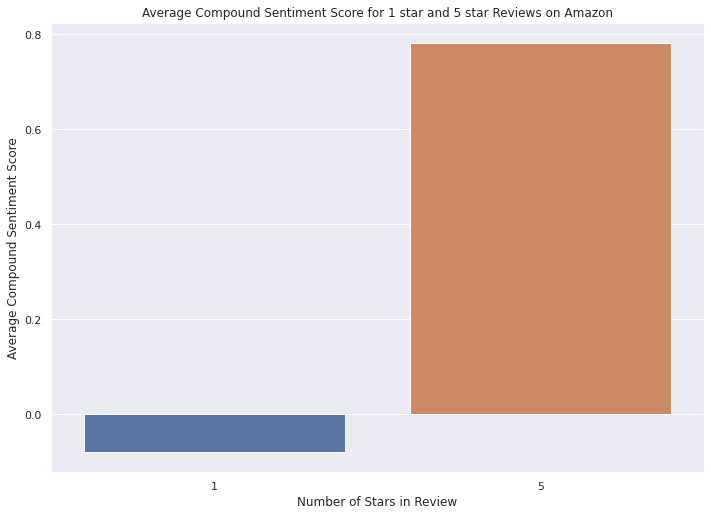

In [15]:
#plot average compound sentiment scores for 1 star and 5 star reviews 

sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})
fig = sns.barplot(x=average.target, y=average.compound).set(title="Average Compound Sentiment Score for 1 star and 5 star Reviews on Amazon")

#specify axis labels
plt.xlabel("Number of Stars in Review")
plt.ylabel("Average Compound Sentiment Score")
plt.savefig('compound.png')
plt.show()


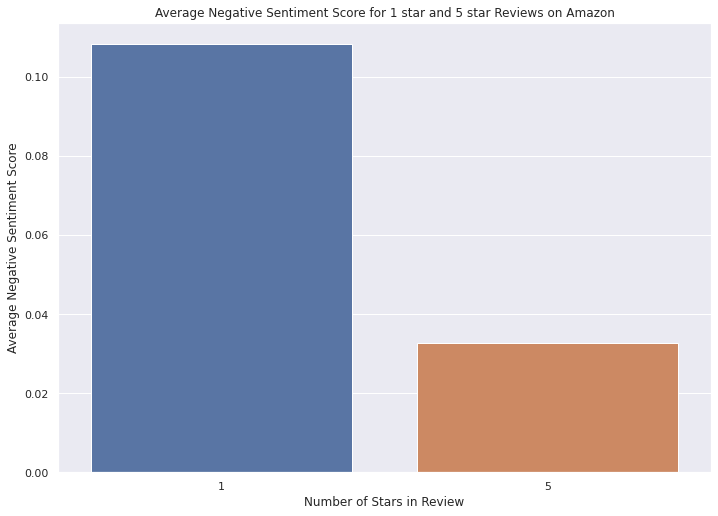

In [16]:
#plot average negative sentiment scores for 1 star and 5 star reviews 

sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.barplot(x=average.target, y=average.neg).set(title="Average Negative Sentiment Score for 1 star and 5 star Reviews on Amazon")

#specify axis labels
plt.xlabel("Number of Stars in Review")
plt.ylabel("Average Negative Sentiment Score")
plt.savefig('negative.png')
plt.show()


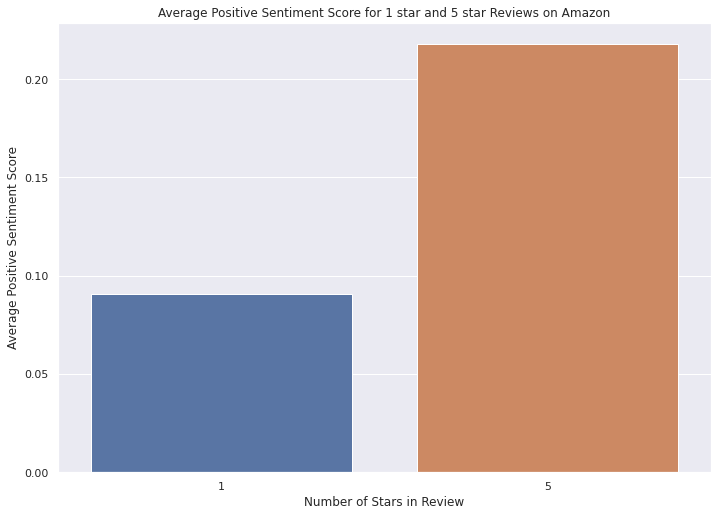

In [17]:
#plot average positive sentiment scores for 1 star and 5 star reviews 

sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})
fig = sns.barplot(x=average.target, y=average.pos).set(title="Average Positive Sentiment Score for 1 star and 5 star Reviews on Amazon")

#specify axis labels
plt.xlabel("Number of Stars in Review")
plt.ylabel("Average Positive Sentiment Score")

plt.show()

In [18]:
#recode 1 and 5 to 0 (negative) and 1 (positive) for analysis 
value_key = {1:0,5:1}
train_df['target'] = train_df['target'].map(value_key)

#view value counts of rating for sampled data and ensure even spread across rating values 
train_df['target'].value_counts()

0    10000
1    10000
Name: target, dtype: int64

In [19]:
#clean text


#create text cleaning function
def to_token(text):


  #keep only alphabet characters
  text = text.str.replace("[^a-zA-Z]", " ")

  return text



In [20]:
#create stopwords collections
stop_words = stopwords.words('english')

def sent_to_words(sentences):
    for sentence in sentences:
        # remove punctuation usng gensim
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]

data = train_df.text.values.tolist()
data_words = list(sent_to_words(data))

# remove stop words
data_words = remove_stopwords(data_words)



In [21]:
# Create Dictionary
id2word = corpora.Dictionary(data_words)

# Create Corpus
texts = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [22]:
#create a topic model for comment data to see trends in negative and positive sentiment

# number of topics
num_topics = 4

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 4 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.017*"book" + 0.011*"one" + 0.010*"great" + 0.008*"would" + 0.007*"read" + '
  '0.007*"movie" + 0.006*"time" + 0.006*"get" + 0.005*"good" + 0.005*"even"'),
 (1,
  '0.018*"book" + 0.012*"like" + 0.011*"one" + 0.007*"cd" + 0.007*"good" + '
  '0.007*"great" + 0.006*"read" + 0.006*"really" + 0.005*"album" + '
  '0.005*"time"'),
 (2,
  '0.007*"book" + 0.006*"one" + 0.005*"like" + 0.004*"would" + 0.004*"buy" + '
  '0.003*"good" + 0.003*"time" + 0.003*"really" + 0.003*"movie" + '
  '0.003*"money"'),
 (3,
  '0.008*"one" + 0.007*"product" + 0.006*"buy" + 0.006*"great" + 0.005*"good" '
  '+ 0.005*"get" + 0.005*"back" + 0.005*"would" + 0.004*"money" + '
  '0.004*"work"')]


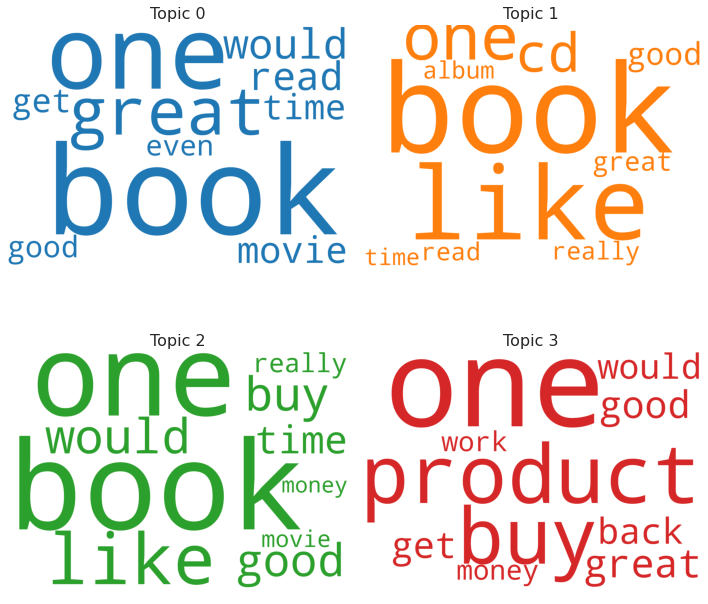

In [23]:
# Create Wordcloud for each topic


cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=900)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.savefig('topics.png')
plt.show()

In [24]:
#clean comment data using text cleaning func
train_df['text'] = to_token(train_df['text'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  if __name__ == '__main__':


In [25]:
# split data into training and validation set and ensure same ratio of classes in both sets
train, val = train_test_split(train_df, stratify = train_df['target'], test_size = 0.2, random_state = 33)


In [26]:
train.head()

,target,text
19634,0,Predictions are way off base I unfortunately o...
6935,1,Intriguing I have always felt I have some pret...
14340,1,Rockstar did it again This is one of the be...
3860,1,A Great Classic I cannot wait for the second D...
19758,0,function of weather vane stake I am totally di...


In [27]:
#verify shape of training and validation data set
train.shape, val.shape

((16000, 2), (4000, 2))

In [28]:
# build a language model from the dataset
data_lm = TextLMDataBunch.from_df(train_df = train, valid_df = val, path = "")


/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(a, dtype=dtype, **kwargs)


In [29]:
#create language model 
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [30]:
#Search for optimal learning rate 
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


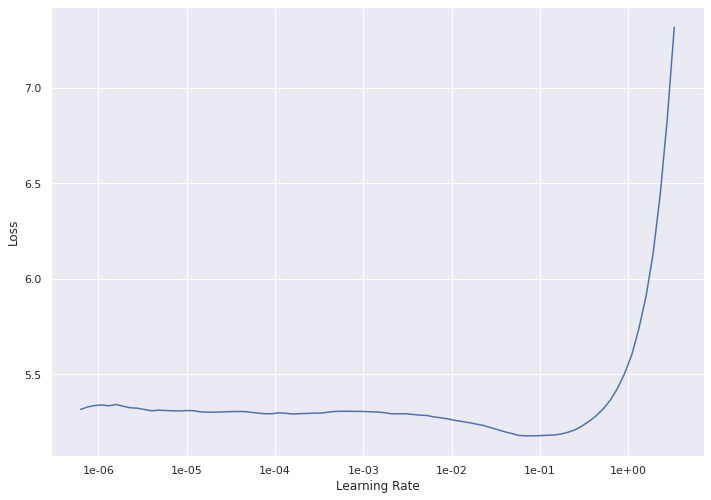

In [31]:
#view plot of learning rates for the model
learn.recorder.plot()

In [32]:
# train the learner object with learning rate = 1e-2
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,4.576082,4.327304,0.242979,02:33


In [34]:
#unfreeze the whole model and train
learn.unfreeze()
learn.fit_one_cycle(1,1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,4.328882,4.197879,0.264905,03:01


In [35]:
#save encoder for classification
learn.save_encoder('amz_enc')

In [36]:
#create a data bunch with batch size 64 
data_clas = TextClasDataBunch.from_df(train_df=train, valid_df = val, path ="", vocab=data_lm.train_ds.vocab, bs=64)

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(a, dtype=dtype, **kwargs)


In [37]:
data_clas.show_batch()

text,target
xxbos xxup the xxup worst xxup of xxup the xxup series i xxup am a xxup huge xxup fan xxup of xxup friday xxup the xxup th xxup and xxup this xxup is xxup the xxup worst xxup one xxup yet xxup compared xxup to xxup part xxup the xxup movie xxup is xxup terrible xxup and xxup jason xxup is xxup on xxup set xxup for xxup only xxup,0
xxbos xxup long xxup lost xxup golden xxup era xxup classic i xxup never xxup heard xxup of xxup these xxup guys xxup before xxup until i xxup listened xxup to xxup the xxup samples xxup of xxup this xxup album i xxup was xxup amazed xxup and xxup blown xxup away xxup these xxup guys xxup would xxup of xxup been xxup right xxup up xxup there xxup with,1
xxbos g xxmaj rap in his prime it s like watching a gangster film xxmaj after dropping two gems on hip hop xxmaj kool g xxmaj rap d j xxmaj polo returned in with the xxup amazing third album g xxmaj rap was still in his prime with xxmaj live xxmaj and xxmaj let xxmaj die an album xxup so gangster it s beautiful xxmaj ever wonder why xxmaj kool,1
xxbos xxmaj good music xxup bad xxup video i bought this xxup dvd recently i love madonna and i have others dvd like xxmaj the xxmaj xxunk xxmaj collection and xxmaj madonna video xxmaj collection i don t understand why xxmaj warner choose the letter box format instead the i don t xxunk too why xxmaj warner don t sell this xxunk in xxmaj blu ray xxmaj other point is,0
xxbos xxmaj worst ever service xxmaj this is the first product i have purchased from xxmaj amazon that has been any issue but non the less it is a total screw job xxmaj the antenna on my modems do not screw off i called for support and they gave me a guy in xxmaj india named xxmaj shawn who was dumber than dirt and twice and arrogant xxmaj he could,0


In [38]:
#Create classifier 
classifier = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
#load encoder for classification
classifier.load_encoder('amz_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (16000 items)
x: TextList
xxbos xxmaj predictions are way off base i unfortunately own this book and the xxunk are flat out wrong xxmaj don t buy this book,xxbos xxmaj intriguing i have always felt i have some pretty good intuition and have wanted to explore it this book has been really interesting and having fun reading,xxbos xxmaj xxunk did it again xxmaj this is one of the best shooters there are xxmaj it has a awsome story line xxmaj the graphics are good but not the best xxmaj actually max s hand is always in the position if he was holding a gun even when he isn t xxmaj the weapons are awsome xxmaj it is hard to choose whitch weapon i would like to use next xxmaj there are two flaws in the game xxmaj one is that the game has no multiplayer xxmaj the other is the game isn t that long but is very fun i have beaten this game times and i m still enjoying it xxmaj the blood and gore is also very realistic i like that for shooters bec

In [39]:
#find optimal learning rate for classifier
classifier.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


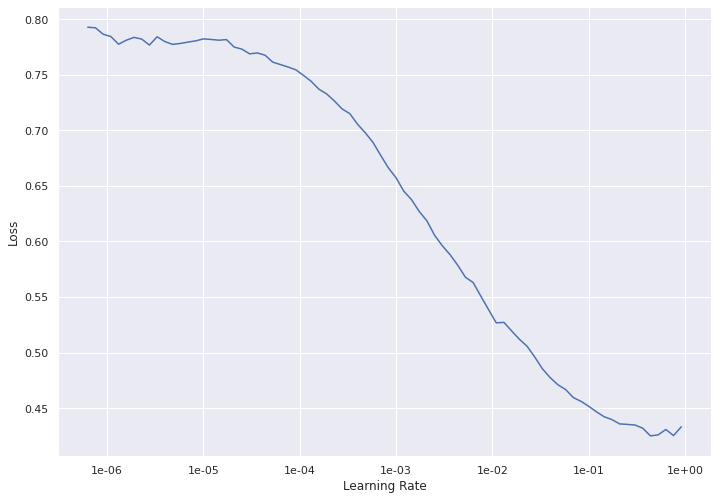

In [40]:
#show plot of learning rate
classifier.recorder.plot()
plt.savefig('class_lr.png')

In [41]:
#train classifier with learning rate = 1e-2
classifier.fit_one_cycle(1, 1e-2, moms =(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.237365,0.179877,0.933000,00:57


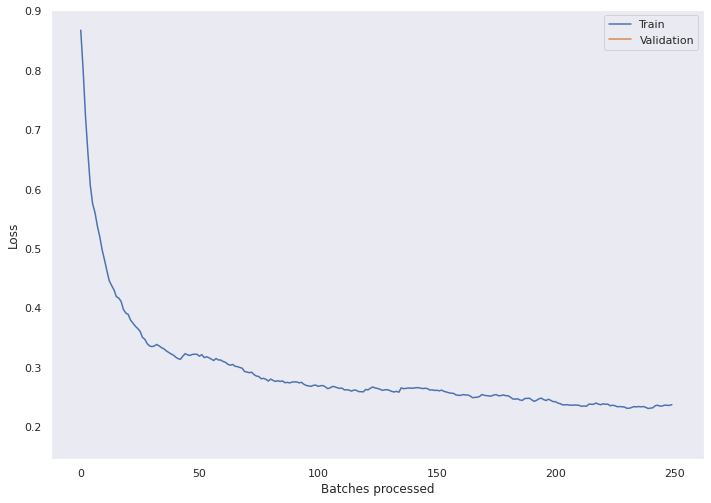

In [42]:
#plot loss while training
classifier.recorder.plot_losses()
plt.savefig('class_loss.png')

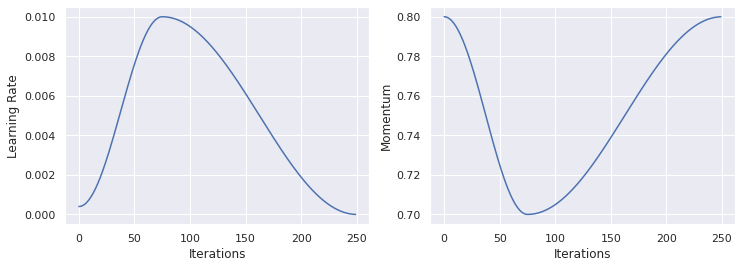

In [43]:
#plot learning rate per batch
classifier.recorder.plot_lr(show_moms=True)

In [44]:
#unfreeze the last two layers of the classifer and train
classifier.freeze_to(-2)
classifier.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.207632,0.159851,0.940250,01:07


In [45]:
#unfreeze the last three layers of the classifer and train
classifier.freeze_to(-3)
classifier.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.164271,0.138206,0.947500,01:43


In [46]:
#unfreeze model and train
classifier.unfreeze()
classifier.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.126990,0.126710,0.953250,02:16


In [47]:
# get predictions
preds, targets = classifier.get_preds()

predictions = np.argmax(preds, axis = 1)
pd.crosstab(predictions, targets)

col_0,0,1
row_0,,
0,1907,94
1,93,1906
